In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from interpret.chefer import *
from models.st_transformer import *
from models.pytorch_lightning import *
from data import *

In [2]:
# : (1) spike and sharp wave (SPSW), 
# (2) generalized periodic epileptiform discharges (GPED), 
# (3) periodic lateralized epileptiform discharges (PLED), 
# (4) eye movement (EYEM), 
# (5) artifact (ARTF) and 
# (6) background (BCKG). 
class_labels = {
    0 : 'Seizure', 1 : 'LPD', 2 : 'GPD', 3 : 'LRDA', 4: 'GRDA', 5 :'Other'
}

In [3]:
# load the dataset

train_loader, test_loader, val_loader, cal_loader = prepare_IIIC_cal_dataloader(drop_last=True)
train = train_loader.dataset
test = test_loader.dataset

107560 13445 35740 13445
210 26 69 26


In [4]:

# # compute percentage of "5" class
# counter = 0
# for i in range(len(train)):
#     signal, label = train[i]
#     if label == 5:
#         counter+=1
        

# print(counter/len(train))

In [4]:
print(len(test))

35740


LRDA
torch.Size([1, 16, 2000])


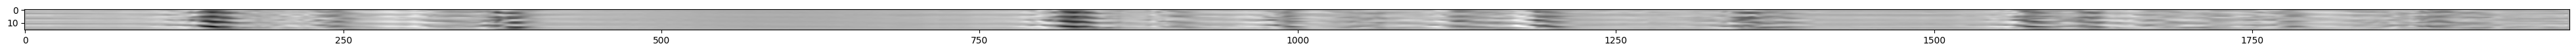

In [5]:
# visualize one example
index = 3120
signal, label = test[index]
signal = signal.unsqueeze(0) # assume batch dim
plt.figure(figsize=(50,50))
# do first 200 to make figure less hard to see.
plt.imshow(signal[:,:,:].squeeze().numpy(), cmap='gray')
plt.savefig(f"fig/int/IIIC_ex{index}.png")
print(class_labels[label])
print(signal.size())

In [7]:
# load the model
# model = STTransformer(depth=4, n_classes=6, channel_length=1000, dropout=0.5)
 # my model hyperparameters
emb_size = 256
depth = 6 
dropout = 0.5
num_heads = 8
patch_kernel_length = 11  # cqi = 15 - UNUSED
stride = 11  # cqi = 8 - UNUSED

model = STTransformer(emb_size=emb_size, 
                                depth=depth,
                                n_classes=6, 
                                channel_length=2000,
                                dropout=dropout, 
                                num_heads=num_heads,
                                kernel_size=11, 
                                stride=11,
                                kernel_size2=11,
                                stride2=11)

model.load_state_dict(torch.load("saved_weights/IIIC_st_transformer_conformal_c11s11c5s5.pt"))


<All keys matched successfully>

In [8]:
# get visualization
model(signal).size()

print(model.channel_attention.get_attn_map().size()) # 1. Can we ignore channel attention? Probably no, because we want to highlight those areas highlighted by channel attention too
print(model.transformer.transformer_blocks[0].mhattn.get_attn_map().size()) # 2. Can we do this first? Yes

torch.Size([1, 16, 16])
torch.Size([1, 8, 21, 21])


Top 5 Scores in Increasing Order
Class LRDA with score: 17.753084182739258
Class GPD with score: 8.140024185180664
Class Seizure with score: -2.48146653175354
Class LPD with score: -5.633268356323242
Class Other with score: -17.757953643798828
True Label: LRDA


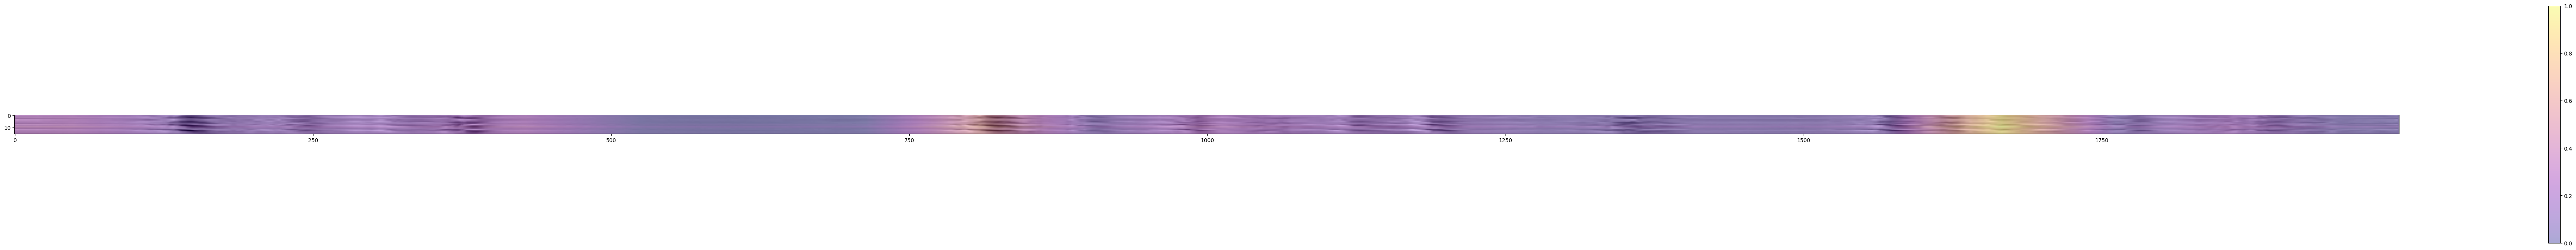

In [12]:
interpreter = STTransformerInterpreter(model=model)
sequence, attribution = interpreter.visualize(signal, class_index = None, save_path="fig/IIIC_seq_highlighted.png", figsize=(100,16), method="linear")
# plt.imshow(vis)
interpreter.get_top_classes(signal, class_labels=class_labels)
print("True Label:", class_labels[label])

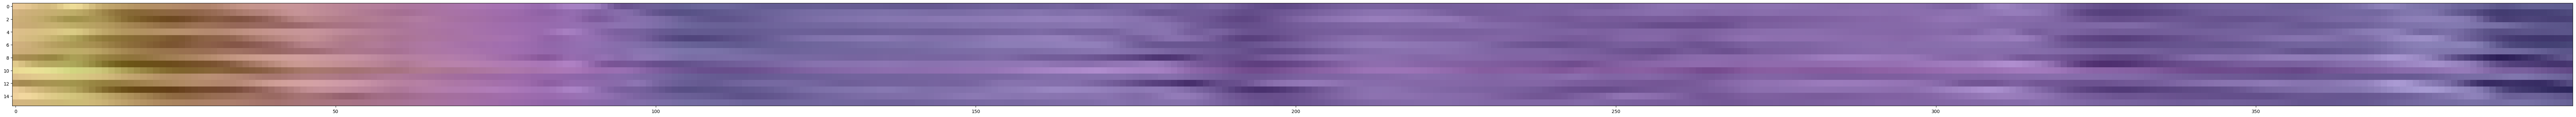

In [11]:
# zooming in on a specific section
start = 800
end = 1200
plt.figure(figsize=(100, 32))
plt.imshow(sequence[:,start:end], cmap='gray')
plt.imshow(attribution[:,start:end], alpha=0.4, cmap='plasma')

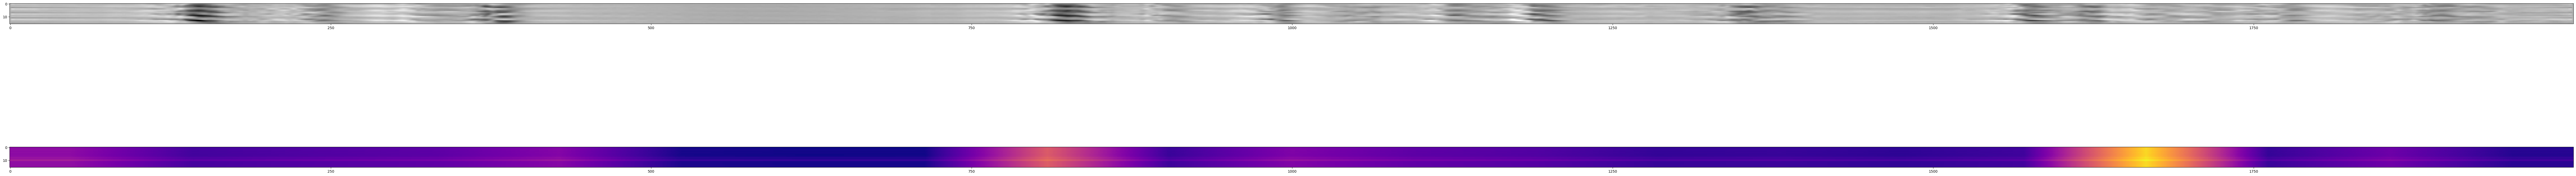

In [13]:
# zoom in on the highlighted features
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(100,16))  # 1 row, 2 columns of subplots


ax1.imshow(sequence, cmap='gray')
ax2.imshow(attribution, cmap='plasma')
plt.tight_layout()
# plt.subplot_tool()
plt.savefig("fig/IIIC_sequence_and_rel_map.png")

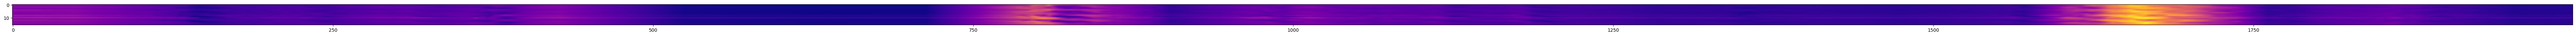

In [14]:
plt.figure(figsize=(100,16))
plt.imshow(sequence * attribution, cmap="plasma")
plt.savefig("fig/IIIC_cam.png")

Zoooming in on the really important stuff.

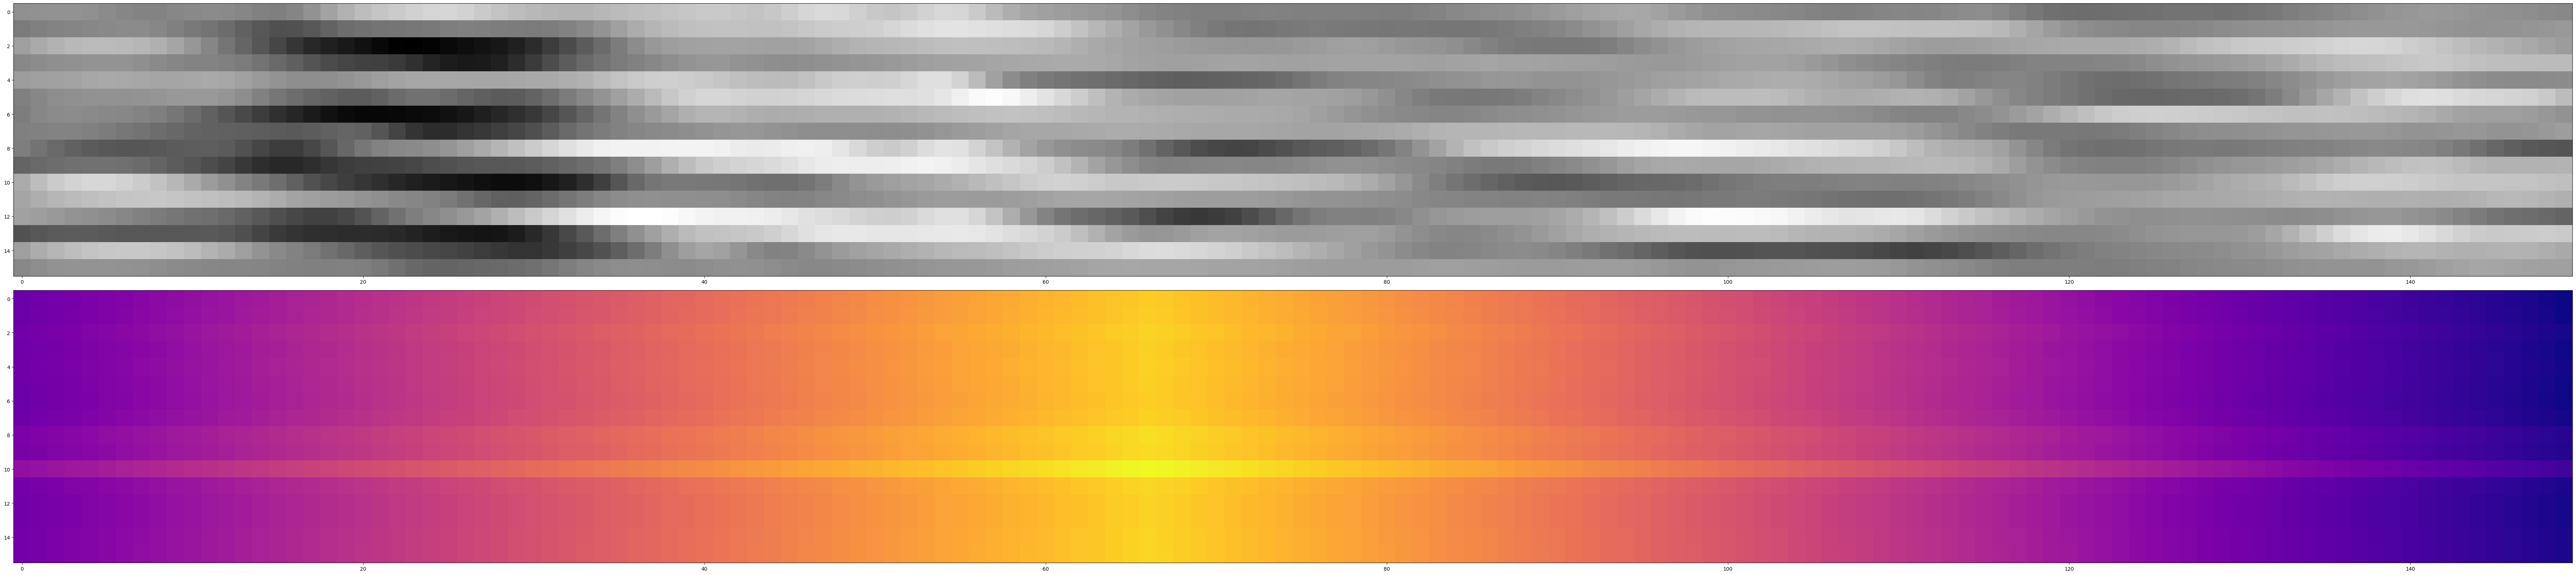

In [17]:
# zoom in on the highlighted features
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(100,16))  # 1 row, 2 columns of subplots


ax1.imshow(sequence[:,1600:1750], cmap='gray')
ax2.imshow(attribution[:,1600:1750], cmap='plasma')
plt.tight_layout()
# plt.subplot_tool()
plt.savefig("fig/IIIC_sequence_and_rel_map_zoomed.png")

[10 10 10 ... 10 10 10]


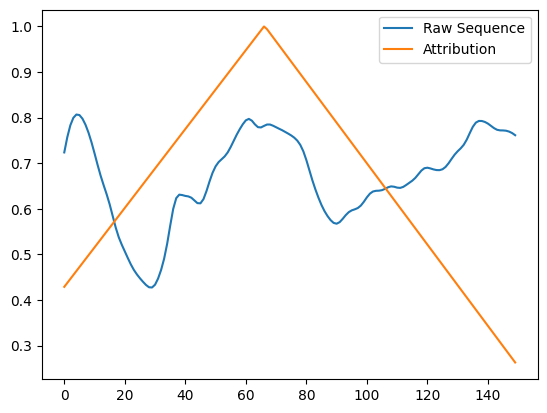

In [26]:
# map out explicitly which is the max channel and, then plot it out in 1D
print(np.argmax(attribution, axis=0))
plt.plot(sequence[10, 1600:1750], label="Raw Sequence")
plt.plot(attribution[10, 1600:1750], label="Attribution")
plt.legend()